# JAX

Loosely following

* https://jax.readthedocs.io/en/latest/quickstart.html

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

## Gradients

Libraries made for Neural networks need to handle auto-differentiation

* TensorFlow 1 allowed derivatives of any variable w.r.t. any other, but this required lots of bookkeeping in the form of a static graph that was updated *every single time* a function was called. This meant that calling a TF function incurred a huge overhead.
* TensorFlow 2 and PyTorch ask you to specify which variables you want gradients of, before you write the corresponding functions
* JAX allows you to write and use functions like normal Numpy, then compute gradients by transforming the functions

See also https://jax.readthedocs.io/en/latest/jit-compilation.html

In [2]:
def square(x):
  return x * x

grad_square = jax.grad(square)  # = 2 * x

print(square(3.))       # = 3 * 3
print(grad_square(3.))  # = 2 * 3

9.0
6.0


In [3]:
# square(a) is computed as:
#   mul(a, a)
print(jax.make_jaxpr(square)(3.))

{ lambda ; a:f32[]. let b:f32[] = mul a a in (b,) }


In [4]:
# grad_square(a) is computed as
#  add(a * 1, 1 * a)
# This is the chain rule applied to f(a) = a * a since then
#   f'(a) = 1 * a + a * 1
print(jax.make_jaxpr(grad_square)(3.))

{ lambda ; a:f32[]. let
    _:f32[] = mul a a
    b:f32[] = mul a 1.0
    c:f32[] = mul 1.0 a
    d:f32[] = add_any c b
  in (d,) }


## **J**ust **I**n **T**ime  Compilation (JIT Compiling)

Libraries for Neural Networks need to efficiently compute large vector operations on CPU/GPU/TPU.

Loosely following
* https://jax.readthedocs.io/en/latest/quickstart.html
* https://jax.readthedocs.io/en/latest/jit-compilation.html

# CPUs vs. GPUs & TPUs

From https://enccs.github.io/gpu-programming/2-gpu-ecosystem/

The CPU programming model is, roughly

* A handfull of very fast threads
* Bottleneck is transferring data from main memory (RAM) into the on-chip memory (cache)

The GPU/TPU programming model is, roughly

* Thousands of slow threads
* On chip memory is limited -- transfer from (CPU) main memory to GPU is slow
* Operations must be carefully planned to utilize GPU effectively

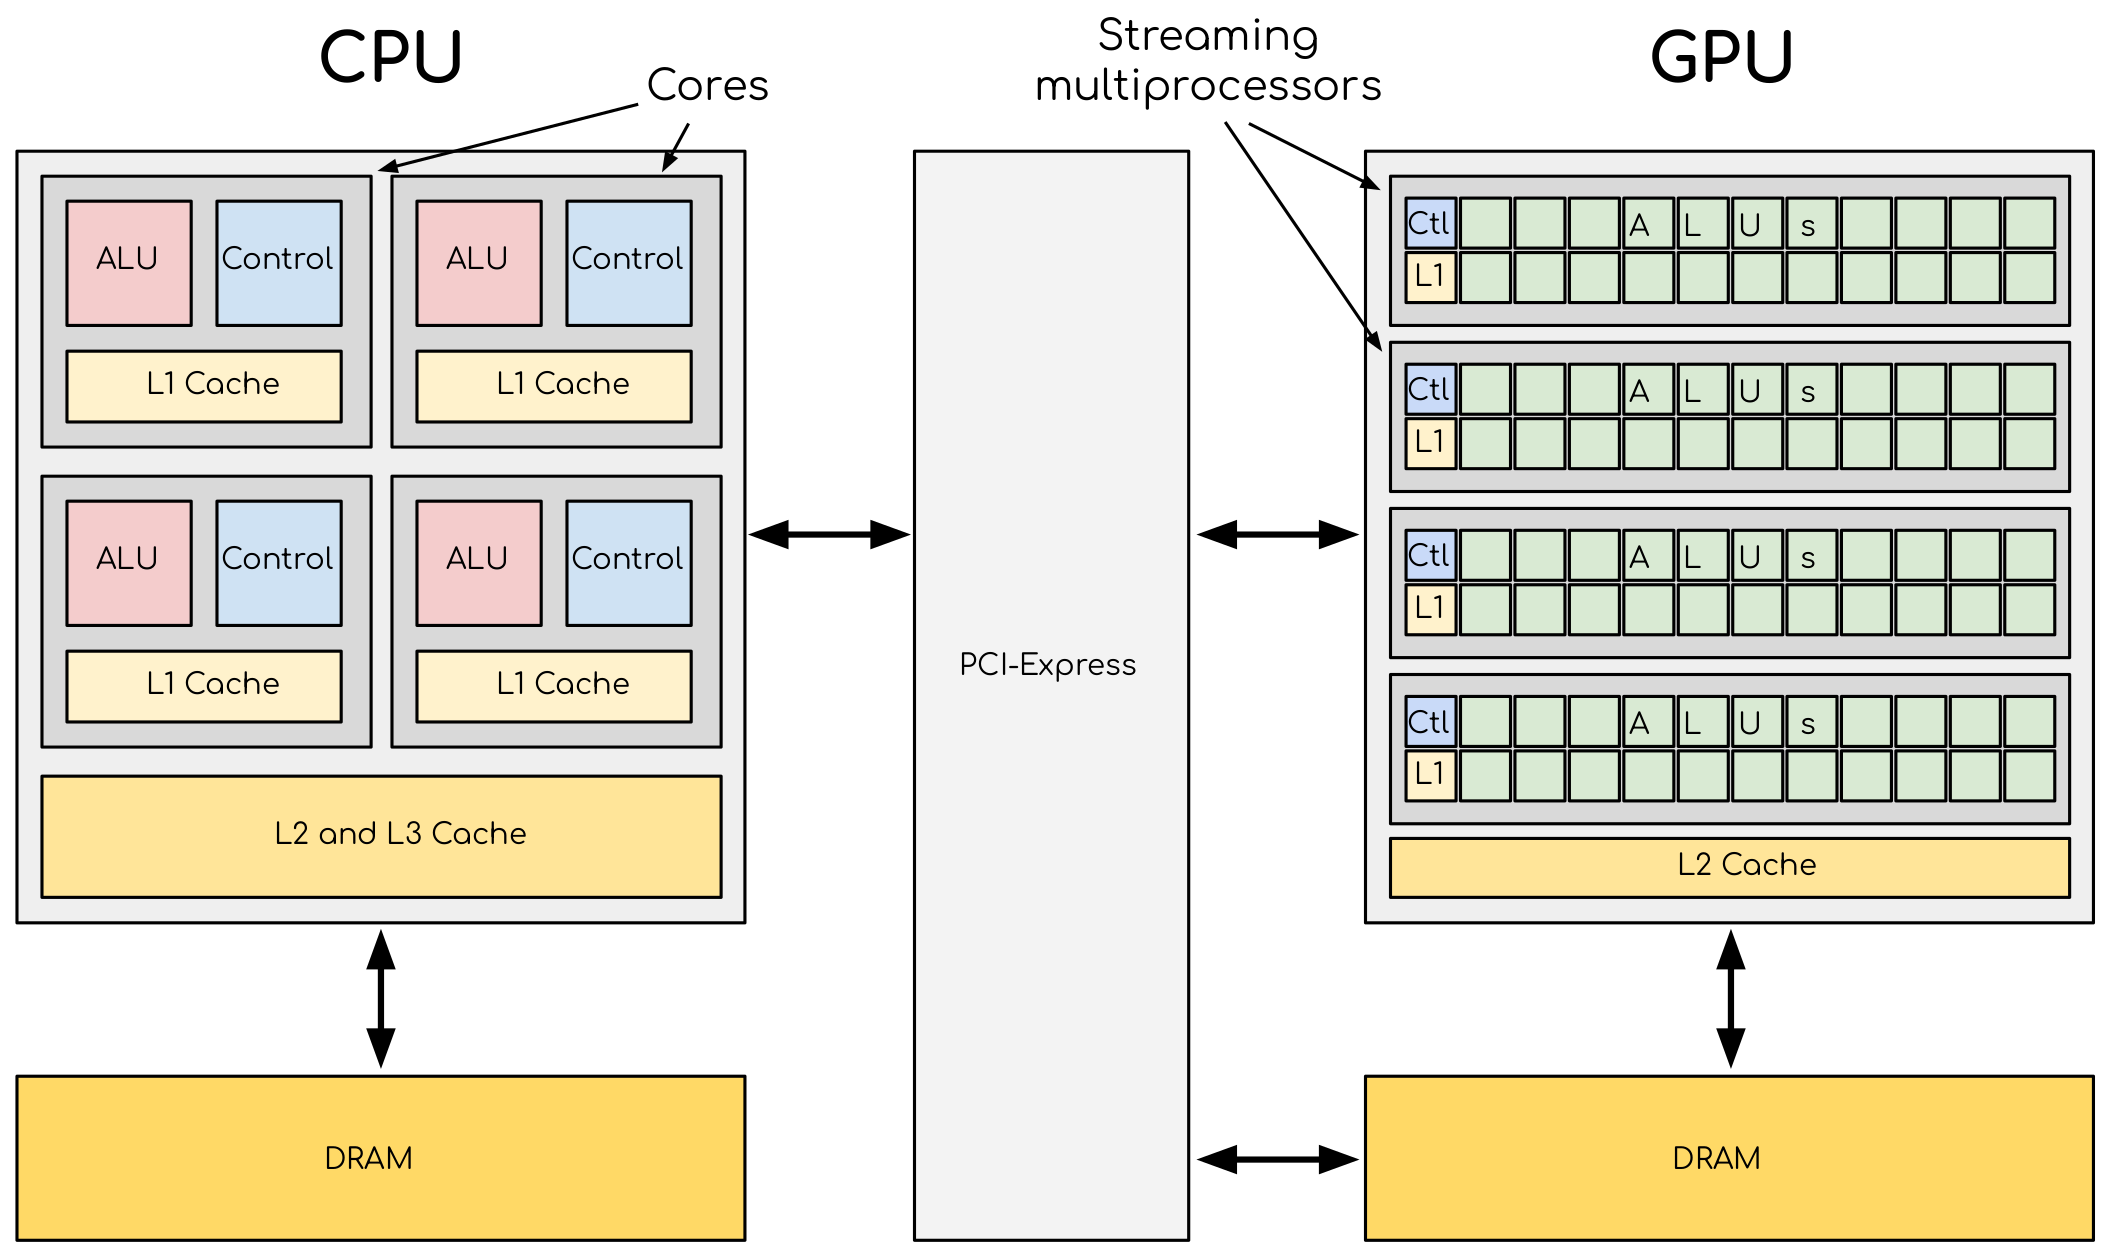

### JIT is used to speed up vectorized operations

In [5]:
# Write some functiont that involves multiple steps
def selu(x, alpha=1.67, lmbda=1.05):
  y_for_negative_x = alpha * jnp.exp(x) - alpha
  return lmbda * jnp.where(x > 0, x, y_for_negative_x)

x = jnp.arange(-5.0, 5.0)
print(selu(x))

[-1.7416848 -1.7213835 -1.6661983 -1.5161895 -1.1084234  0.
  1.05       2.1        3.1499999  4.2      ]


In [6]:
key = jax.random.key(1701)
x = jax.random.normal(key, (1_000_000,))  # 1M random numbers
%timeit selu(x).block_until_ready()

25.2 ms ± 9.17 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
selu_jit = jax.jit(selu)
_ = selu_jit(x)  # compiles on first call
%timeit selu_jit(x).block_until_ready()

2.72 ms ± 321 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### JIT compilation and pure functions

* JIT compilation runs the function with a `Tracer` that "records" what the function does to `Array` objects *only*
* Python side effects are not recorded, and will be executed only when tracing
* If Array-like inputs change dtype/shape, the function is re-compiled
* If "static" args change at all, then the function is re-compiled

In [8]:
global_list = []

def log2(x):
  global_list.append(x)
  ln_x = jnp.log(x)
  ln_2 = jnp.log(2.0)
  return ln_x / ln_2

# Notice that appending to `global_list` is *not* included in the expression
print(jax.make_jaxpr(log2)(3.0))

{ lambda ; a:f32[]. let
    b:f32[] = log a
    c:f32[] = log 2.0
    d:f32[] = div b c
  in (d,) }


In [9]:
jit_log2 = jax.jit(log2)

for x in [1., 2., 3., 4.]:
  print(f'\n{x=}')
  print(jit_log2(x))
  print(f'{len(global_list)=}')  # = 2, 1 entry for when we made the jaxpr, the other for when we compiled it


x=1.0
0.0
len(global_list)=2

x=2.0
1.0
len(global_list)=2

x=3.0
1.5849625
len(global_list)=2

x=4.0
2.0
len(global_list)=2


In [10]:
# The list contains tracers, not the numeric values you passed in
global_list[1]

Traced<ShapedArray(float32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)>

In [11]:
# While loop conditioned on x and n.

def g(x, n):
  i = 0
  while i < n:
    i += 1
  return x + i

jit_g = jax.jit(g)
jit_g(10, 20)  # Raises an error

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[]..
The error occurred while tracing the function g at <ipython-input-11-8b4c0f215324>:3 for jit. This concrete value was not available in Python because it depends on the value of the argument n.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [12]:
jit_g = jax.jit(g, static_argnames=['n'])
print(jit_g(10, 20))  # Compiles first time through, then executes
print(jit_g(11, 20))  # Executes
print(jit_g(11, 21))  # Must recompile first, since a static arg changed

30
31
32


# Example: Gradient Descent in JAX

In [13]:
from jax.typing import ArrayLike
Array = jax.Array
from jax.random import PRNGKey, normal, fold_in

In [14]:
@jax.jit
def forward_model(alpha, coeff, noise_level, key) -> Array:
  noiseless_prediction = coeff * alpha
  noise = noise_level * normal(key, shape=noiseless_prediction.shape)
  return noiseless_prediction + noise

coeff_true = 1.2
noise_level_true = 0.1

n_samples = 10000
training_alphas = normal(key=PRNGKey(0), shape=(n_samples,))

observations = forward_model(training_alphas, coeff_true, noise_level_true, key=PRNGKey(1))

print(f'{observations.shape=}')

observations.shape=(10000,)


In [59]:
def loss_fn(params, observation, alpha, key) -> Array:
  coeff = params['coeff']
  noise_level = params['noise_level']
  assert observation.ndim == 1, f'{observation.ndim=}'
  prediction = forward_model(alpha, coeff, noise_level, key)
  prediction_prime = forward_model(alpha, coeff, noise_level, fold_in(key, 1))
  assert prediction.shape == observation.shape, f'{prediction.shape=} and {observation.shape=}'

  # spread is |X - X'|
  # two_x_skill is |X - Y| + |X' - Y|
  spread = jnp.abs(prediction - prediction_prime)
  two_x_skill = jnp.abs(prediction - observation) + jnp.abs(prediction_prime - observation)

  return jnp.mean(two_x_skill - spread)

# Gradient w.r.t. the first argument, `params`
value_and_grad_loss = jax.jit(jax.value_and_grad(loss_fn))

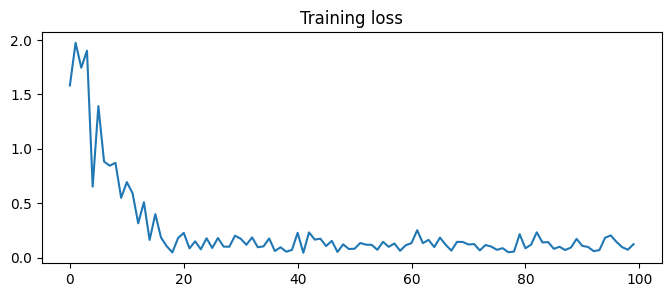

In [60]:
minibatch_size = 10
n_iterations = 100
learning_rate = 0.05

params = {
  'coeff': 0.,
  'noise_level': 0.001,
}

key = PRNGKey(802701)

losses = []
for iteration in range(n_iterations):
  key = jax.random.fold_in(key, iteration)
  choice_key, loss_key = jax.random.split(key)
  indices = jax.random.choice(choice_key, jnp.arange(n_samples), shape=(minibatch_size,))
  minibatch_alpha = jnp.take_along_axis(training_alphas, indices, axis=0)
  minibatch_obs = jnp.take_along_axis(observations, indices, axis=0)
  loss, grads = value_and_grad_loss(params, minibatch_obs, minibatch_alpha, loss_key)
  losses.append(loss)
  for name, grad_value in grads.items():
    params[name] -= learning_rate * grad_value

fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(losses); ax.set_title(f'Training loss');

In [48]:
print(f'{coeff_true=} {noise_level_true=}')
print(params)

coeff_true=1.2 noise_level_true=0.1
{'coeff': Array(1.1655765, dtype=float32, weak_type=True), 'noise_level': Array(0.08819555, dtype=float32, weak_type=True)}


### Things to try

* Change the loss function (e.g. to MSE) and see what happens to the fitted parameters

# JAX-CFD

* Following https://github.com/google/jax-cfd/blob/main/notebooks/spectral_forced_turbulence.ipynb

In [1]:
!pip install jax-cfd xarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.4/215.4 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 10.7 MB/s eta 0:00:00


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import xarray

import jax_cfd.base as cfd
import jax_cfd.base.grids as grids
import jax_cfd.spectral as spectral

import dataclasses

## Decaying turbulence

In [3]:
%%time

# physical parameters
viscosity = 1e-3
max_velocity = 7
grid = grids.Grid((256, 256), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))
dt = cfd.equations.stable_time_step(max_velocity, .5, viscosity, grid)

# setup step function using crank-nicolson runge-kutta order 4
smooth = True # use anti-aliasing
step_fn = spectral.time_stepping.crank_nicolson_rk4(
    spectral.equations.NavierStokes2D(viscosity, grid, smooth=smooth), dt)

# run the simulation up until time 25.0 but only save 10 frames for visualization
final_time = 25.0
outer_steps = 10
inner_steps = (final_time // dt) // 10

trajectory_fn = cfd.funcutils.trajectory(
    cfd.funcutils.repeated(step_fn, inner_steps), outer_steps)

# create an initial velocity field and compute the fft of the vorticity.
# the spectral code assumes an fft'd vorticity for an initial state
v0 = cfd.initial_conditions.filtered_velocity_field(jax.random.PRNGKey(42), grid, max_velocity, 4)
vorticity0 = cfd.finite_differences.curl_2d(v0).data
vorticity_hat0 = jnp.fft.rfftn(vorticity0)

_, trajectory = trajectory_fn(vorticity_hat0)

CPU times: user 22.2 s, sys: 13.9 s, total: 36 s
Wall time: 20.7 s


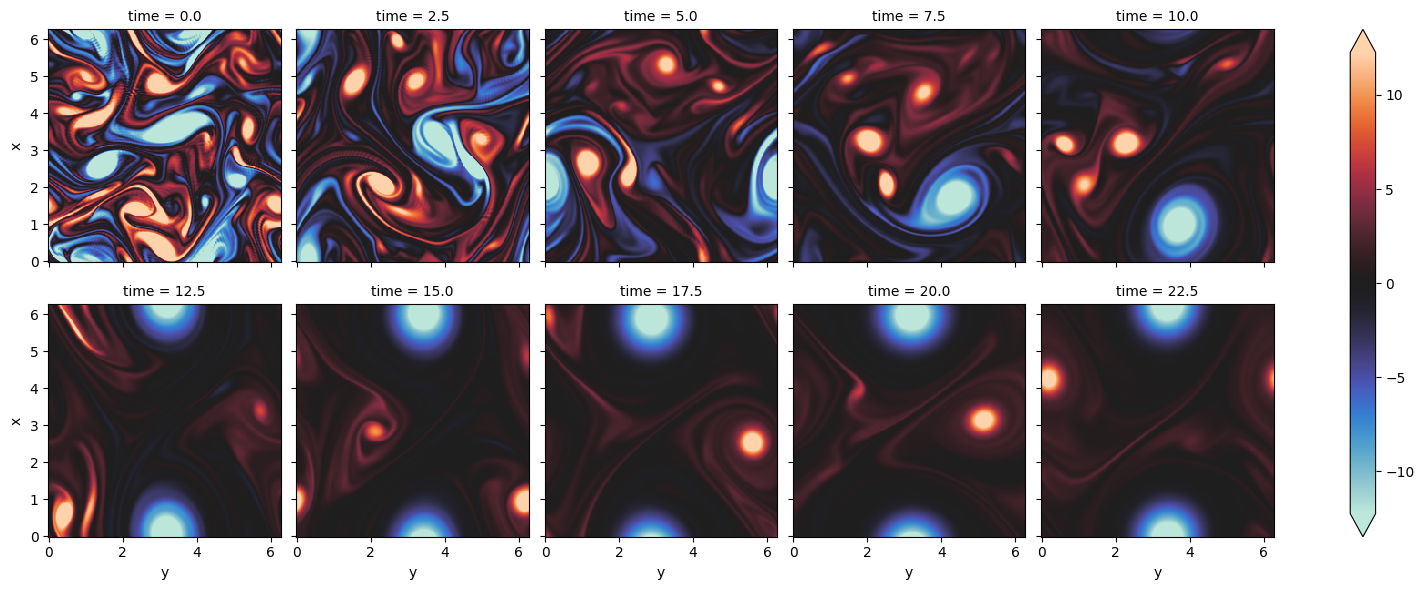

In [4]:
# transform the trajectory into real-space and wrap in xarray for plotting
spatial_coord = jnp.arange(grid.shape[0]) * 2 * jnp.pi / grid.shape[0] # same for x and y
coords = {
  'time': dt * jnp.arange(outer_steps) * inner_steps,
  'x': spatial_coord,
  'y': spatial_coord,
}
xarray.DataArray(
    jnp.fft.irfftn(trajectory, axes=(1,2)),
    dims=["time", "x", "y"], coords=coords).plot.imshow(
        col='time', col_wrap=5, cmap=sns.cm.icefire, robust=True);

## Forced turbulence

In [5]:
%%time

# physical parameters
viscosity = 1e-3
max_velocity = 7
grid = grids.Grid((256, 256), domain=((0, 2 * jnp.pi), (0, 2 * jnp.pi)))
dt = cfd.equations.stable_time_step(max_velocity, .5, viscosity, grid)

# setup step function using crank-nicolson runge-kutta order 4
smooth = True # use anti-aliasing


# **use predefined settings for Kolmogorov flow**
step_fn = spectral.time_stepping.crank_nicolson_rk4(
    spectral.equations.ForcedNavierStokes2D(viscosity, grid, smooth=smooth), dt)


# run the simulation up until time 25.0 but only save 10 frames for visualization
final_time = 25.0
outer_steps = 10
inner_steps = (final_time // dt) // 10

trajectory_fn = cfd.funcutils.trajectory(
    cfd.funcutils.repeated(step_fn, inner_steps), outer_steps)

# create an initial velocity field and compute the fft of the vorticity.
# the spectral code assumes an fft'd vorticity for an initial state
v0 = cfd.initial_conditions.filtered_velocity_field(jax.random.PRNGKey(42), grid, max_velocity, 4)
vorticity0 = cfd.finite_differences.curl_2d(v0).data
vorticity_hat0 = jnp.fft.rfftn(vorticity0)

_, trajectory = trajectory_fn(vorticity_hat0)

CPU times: user 15.4 s, sys: 9.64 s, total: 25 s
Wall time: 5.47 s


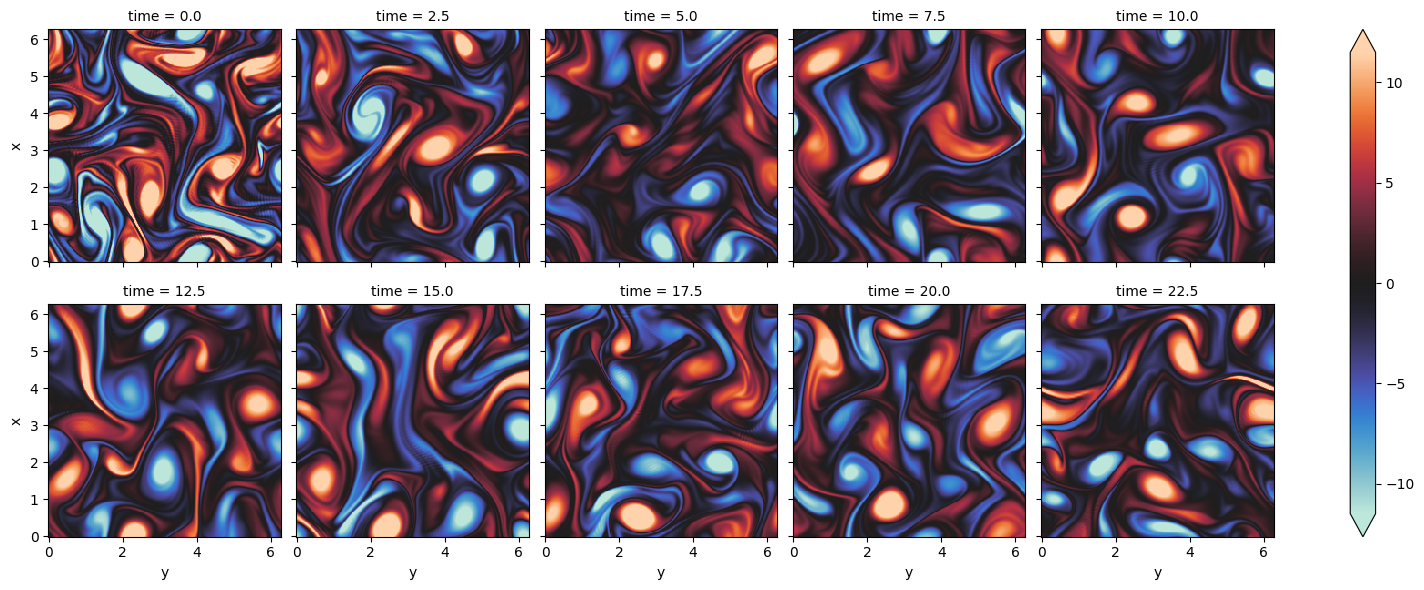

In [6]:
# transform the trajectory into real-space and wrap in xarray for plotting
spatial_coord = jnp.arange(grid.shape[0]) * 2 * jnp.pi / grid.shape[0] # same for x and y
coords = {
  'time': dt * jnp.arange(outer_steps) * inner_steps,
  'x': spatial_coord,
  'y': spatial_coord,
}
xarray.DataArray(
    jnp.fft.irfftn(trajectory, axes=(1,2)),
    dims=["time", "x", "y"], coords=coords).plot.imshow(
        col='time', col_wrap=5, cmap=sns.cm.icefire, robust=True);